## Model Initialization and Cross Validation

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap

/Users/midorikawaguti/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the Data
heart_df = pd.read_csv("../../TeamProject/data/raw/heart.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## StandardScaler in Scikit-Learn for continuous numerical features: Age, RestingBP, Cholesterol, MaxHR, Oldpeak

In [3]:
numerical_features = heart_df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale all the features in the dataset
scaled_features = scaler.fit_transform(numerical_features)

# Create a new DataFrame with scaled features
numerical_scaled_heart_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)

# Display the first few rows of the scaled DataFrame
print(numerical_scaled_heart_df.head())

        Age  RestingBP  Cholesterol     MaxHR   Oldpeak
0 -1.433140   0.410909     0.825070  1.382928 -0.832432
1 -0.478484   1.491752    -0.171961  0.754157  0.105664
2 -1.751359  -0.129513     0.770188 -1.525138 -0.832432
3 -0.584556   0.302825     0.139040 -1.132156  0.574711
4  0.051881   0.951331    -0.034755 -0.581981 -0.832432


In [4]:
categorical_features = heart_df
categorical_features = categorical_features.drop(columns=numerical_features)

# Concatenate scaled numeric features with categorical features
scaled_heart_df = pd.concat([numerical_scaled_heart_df, categorical_features], axis=1)
scaled_heart_df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,M,ATA,0,Normal,N,Up,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,F,NAP,0,Normal,N,Flat,1
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,M,ATA,0,ST,N,Up,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,F,ASY,0,Normal,Y,Flat,1
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,M,NAP,0,Normal,N,Up,0


##  Transform Categorical Variables
Transformation of categorical values ​​into numerical ones to work with machine learning models that require numerical inputs, such as KNN, which rely on distance calculations between data points.

| Feature | Type | Encoding Method | Why? |
|----------|----------|----------|----------|
| Sex   |Binary  | 0/1 Mapping   | Only Two Categories |
| ExerciseAngina   | Binary  | 0/1 Mapping  | Only two categories |
| ChestPainType   | Categorical  | One-Hot Encoding  | No meaningful order |
| RestingECG   | Categorical  | One-Hot Encoding  | No meaningful order |
| ST_Slope   | Ordered  | Ordinal Encoding  | Has a meaningful order |


In [5]:
# Sex (M, F) -> Convert to binary:
scaled_heart_df['Sex'] = scaled_heart_df['Sex'].map({'M': 1, 'F': 0})
# ChestPainType (TA, ATA, NAP, ASY)- categories with no meaninful order → Use One-Hot Encoding (creates separate binary columns (0 or 1) for each category):
scaled_heart_df = pd.get_dummies(scaled_heart_df, columns=['ChestPainType'], drop_first=True)
# RestingECG (Normal, ST, LVH) → One-Hot Encoding:
scaled_heart_df = pd.get_dummies(scaled_heart_df, columns=['RestingECG'], drop_first=True)
# ExerciseAngina (Y, N) → Binary Encoding:
scaled_heart_df['ExerciseAngina'] = scaled_heart_df['ExerciseAngina'].map({'Y': 1, 'N': 0})
# ST_Slope - meaningful order: Up > Flat > Down → Ordinal Encoding (ordered categories):
slope_mapping = {'Up': 2, 'Flat': 1, 'Down': 0}
scaled_heart_df['ST_Slope'] = scaled_heart_df['ST_Slope'].map(slope_mapping)

## Converting True/False to 0/1 to prevent errors in models

In [6]:
scaled_heart_df[["ChestPainType_ATA", "ChestPainType_NAP", "ChestPainType_TA", "RestingECG_Normal", "RestingECG_ST"]] = scaled_heart_df[["ChestPainType_ATA", "ChestPainType_NAP", "ChestPainType_TA", "RestingECG_Normal", "RestingECG_ST"]].astype(int)  # Convert True/False to 0/1
scaled_heart_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,1,0,0,2,0,1,0,0,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,0,0,0,1,1,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,1,0,0,2,0,1,0,0,0,1
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,0,0,1,1,1,0,0,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,1,0,0,2,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,-1.210356,0.596393,-0.188999,0.293283,1,0,0,1,1,0,0,1,1,0
914,1.536902,0.627078,-0.053049,0.164684,2.357094,1,1,0,1,1,0,0,0,1,0
915,0.370100,-0.129513,-0.620168,-0.857069,0.293283,1,0,1,1,1,0,0,0,1,0
916,0.370100,-0.129513,0.340275,1.461525,-0.832432,0,0,0,1,1,1,0,0,0,0


In [7]:
# Select predictors 
predictors_standardized = scaled_heart_df.loc[:, scaled_heart_df.columns != 'HeartDisease']

In [8]:
np.random.seed(123)
# Create a random vector of True and False values to split the data
split = np.random.choice([True, False], size=len(predictors_standardized), replace=True, p=[0.75, 0.25])

X_train = predictors_standardized[split == True]
X_test = predictors_standardized[split == False]

y_train = scaled_heart_df.loc[split, scaled_heart_df.columns[scaled_heart_df.columns=="HeartDisease"][0]]
y_test = scaled_heart_df.loc[~split, scaled_heart_df.columns[scaled_heart_df.columns=="HeartDisease"][0]]

In [9]:
# Initialize the KNN classifier using `KNeighborsClassifier()`
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [10]:
# Define a parameter grid for `n_neighbors` ranging from 1 to 50.
parameter_grid = {
    "n_neighbors": range(1,51)
}

#Implement a grid search using `GridSearchCV` with 10-fold cross-validation to find the optimal number of neighbors.
heart_tune_grid = GridSearchCV(
    estimator = knn,
    param_grid=parameter_grid,
    cv=10
)

#After fitting the model on the training data, identify and return the best value for `n_neighbors` based on the grid search results.
heart_tune_grid.fit(
    X_train,
    y_train
)

accurancies_grid = pd.DataFrame(heart_tune_grid.cv_results_)

#### Model evaluation

Using the best value for `n_neighbors`, fit a KNN model on the training data and evaluate its performance on the test set using `accuracy_score`.

In [11]:
best_param = heart_tune_grid.best_params_["n_neighbors"]
print(f'Best K:{best_param}')
knn = KNeighborsClassifier(n_neighbors=best_param)

Best K:21


In [12]:
# Fit the model on the training data
knn.fit(
    X_train, 
    y_train
)

#Evaluate its performance on the test set using `accuracy_score`.
y_pred = knn.predict(X_test)

In [13]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       102
           1       0.86      0.91      0.88       130

    accuracy                           0.86       232
   macro avg       0.86      0.86      0.86       232
weighted avg       0.86      0.86      0.86       232



In [14]:
test_accuracy = accuracy_score(y_test, y_pred )
print(f'Accuracy: {test_accuracy:.2f}')

Accuracy: 0.86


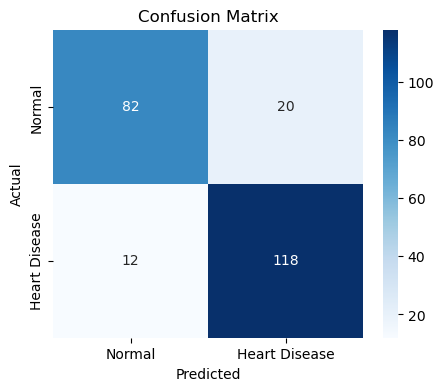

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Normal", "Heart Disease"], yticklabels=["Normal", "Heart Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
knn

KNeighborsClassifier(n_neighbors=21)

In [17]:
heart_tune_grid.best_estimator_

KNeighborsClassifier(n_neighbors=21)

In [53]:
# probability of being class 0 and 1.  0- normal| 1- heart disease. Values sum 1.
knn.predict_proba(X_train)#[:, 1]

array([[0.95238095, 0.04761905],
       [0.71428571, 0.28571429],
       [0.9047619 , 0.0952381 ],
       ...,
       [0.28571429, 0.71428571],
       [0.33333333, 0.66666667],
       [0.0952381 , 0.9047619 ]])

In [46]:
X_train.median().values#.reshape((1, X_train.shape[1]))

array([ 0.05188098, -0.12951283,  0.21678969,  0.04678968, -0.36338443,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

In [48]:
X_train.median().values.reshape((1, X_train.shape[1]))

array([[ 0.05188098, -0.12951283,  0.21678969,  0.04678968, -0.36338443,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ]])

In [62]:
X_train#.median().values.reshape((1, X_train.shape[1]))

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,1,0,0,2,1,0,0,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,0,0,0,1,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,1,0,0,2,1,0,0,0,1
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,0,0,1,1,0,0,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,1,0,0,2,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,-1.327067,-0.669935,-0.382344,1.775910,-0.832432,1,0,0,2,1,0,0,1,0
911,0.582246,1.707921,-0.208549,-1.839524,0.105664,1,1,0,1,0,0,0,0,0
912,0.370100,0.410909,0.386011,-0.542683,-0.644813,0,0,1,1,0,0,0,1,0
913,-0.902775,-1.210356,0.596393,-0.188999,0.293283,1,0,0,1,0,0,1,1,0


In [61]:
knn

KNeighborsClassifier(n_neighbors=21)

In [ ]:
def f(x):
    # get the columns for the positive class (class 1) - 1D array
    return knn.predict_proba(x)[:, 1]

# calculate the median values for each feature in the training dataset - results in a 2D array
med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med, seed=42)
shap_values = explainer(X_test.iloc[0:232, :])

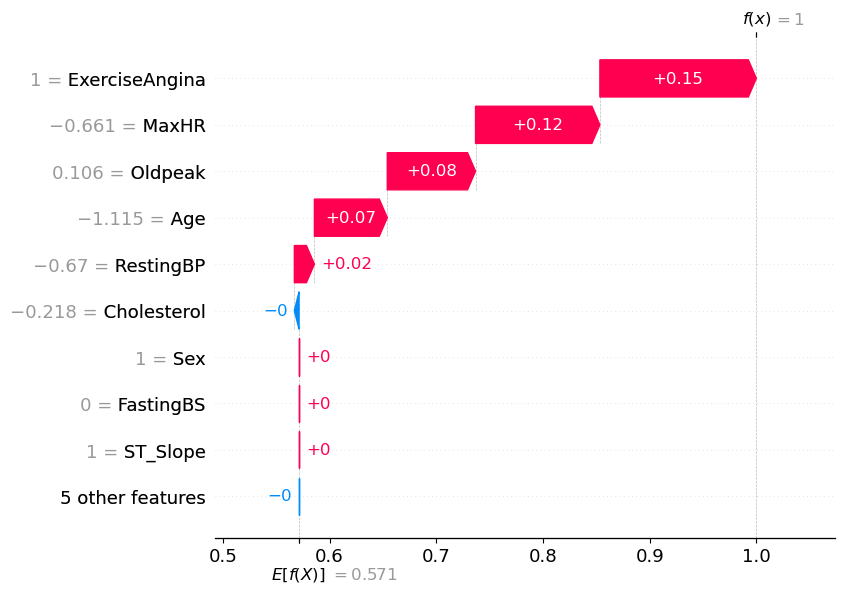

In [59]:
# SHAP Waterfall plot for one sample in the test dataset (5th sample in the dataset)
shap.plots.waterfall(shap_values[4])

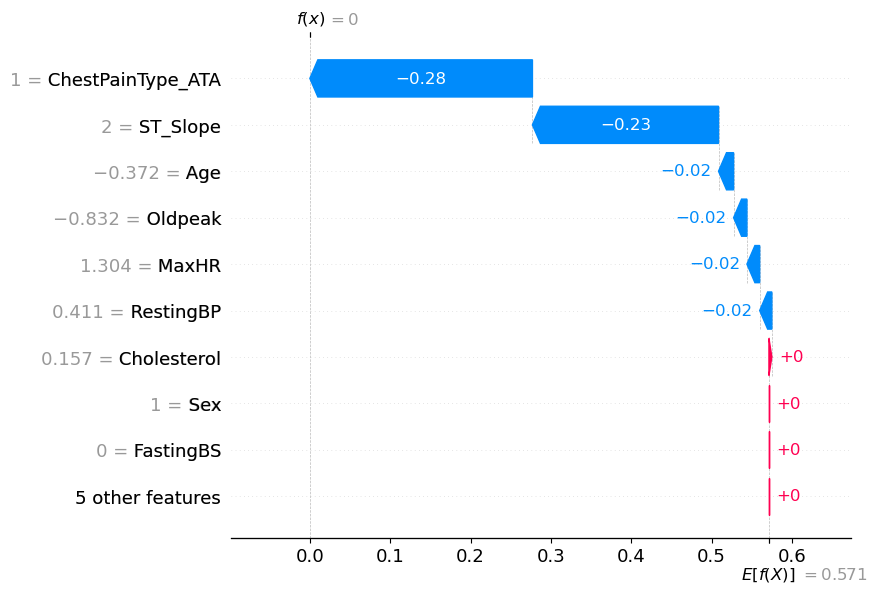

In [63]:
shap.plots.waterfall(shap_values[5])

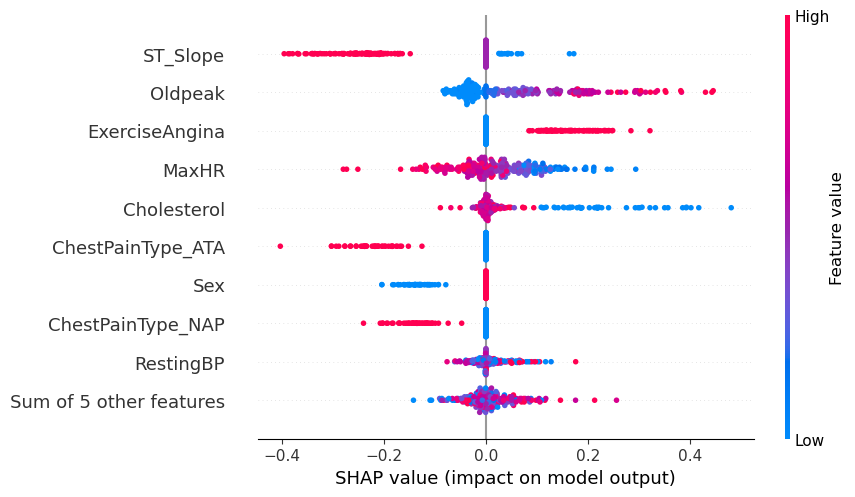

In [60]:
shap.plots.beeswarm(shap_values)
